This notebook is based off of Fatima's `peak_fit_trend_SFR.ipynb` notebook and is designed to compute and plot the luminosity as a function of depth inside the V$^2$ voids.

This analysis requires binning the V$^2$ galaxies by their normalized depth inside a void and fitting the resulting distirbution in $M_r$.  We then compute the ratio of the means of the two skew normal distributions at each depth value.

In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import fits

from scipy.optimize import curve_fit, minimize_scalar
from scipy.stats import skewnorm

from functions import model_skew, estimate_Jacobian, depth_plot

import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdul = fits.open(filename)
data = Table(hdul[1].data)
hdul.close()

## Just keep the main SDSS DR7 footprint

In [3]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [4]:
# Also only keep those within the redshift limit of the void catalogs
vollim = catalog_main[catalog_main['Z'] <= 0.114]

## Separate galaxies by their LSS classifications

### $V^2$

In [5]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [6]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# $M_r$ as a function of void depth

Bin the V$^2$ void galaxies by how far from their void boundary they are, and plot the location of the $M_r$ peak in that bin as a function of the distance from the void boundary.  The plot will be cumulative from the inside of a void out, so we are really trying to find the "true" void galaxy population using V$^2$.

In [7]:
def func_unimodal(x, a, mu, sg, skew):
    """
    One skew normal distribution
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a : float
        amplitude of the skew normal distribution
        
    mua : float
        location of the skew normal distribution
        
    sg : float
        width of the skew normal distribution
        
    skew : float
        skew of the skew normal distribution
    

    Returns
    -------
    model : float or ndarray
        Model evaluated at x.
    """

    return a*skewnorm.pdf(x, skew, loc=mu, scale=sg)


def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    """
    Mixture of two skew normal distributions.
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a, b : float
        amplitudes of the skew normal distributions
        
    mua, mub : float
        locations of the skew normal distributions
        
    sga, sgb : float
        widths of the skew normal distributions
        
    askew, bskew : float
        skews of the skew normal distributions
    

    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """

    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + \
           b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)

In [8]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)

    dn1 = np.sqrt(n1)

    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x, n1, dn1 #, popt_void

In [9]:
def fit_unimodal(char_, bins, class_=None, p0_=None, err=None, label=''):
    
    if class_ is None:
        x_data, y_data, dy = bin_data(data=char_, bins_=bins)
    else:
        x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = dy
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, model_skew(popt_, x_data), 'k')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    #return popt_, np.sqrt(np.diag(pcov_))
    return popt_, pcov_


def fit_bimodal(char_, bins, class_=None, p0_=None, err=None, label=''):
    
    if class_ is None:
        x_data, y_data, dy = bin_data(data=char_, bins_=bins)
    else:
        x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = dy
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.plot(x_data, model_skew(popt_[:4], x_data), 'r')
    plt.plot(x_data, model_skew(popt_[4:], x_data), 'b')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    #return popt_, np.sqrt(np.diag(pcov_))
    return popt_, pcov_

# How does the location of the maximum in the $M_r$ distribution depend on depth in the V$^2$ voids?

In [10]:
rabsmag_bins = np.arange(-24, -14, 0.1)

## Full sample

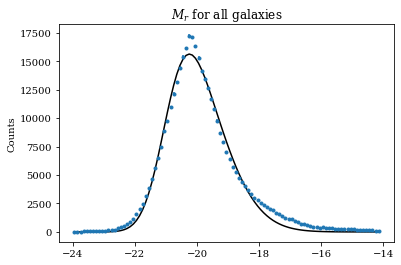

[ 3.58447900e+04 -2.09726618e+01  1.39521081e+00  2.19095013e+00] [3.78648661e+02 2.29901645e-02 3.13016370e-02 1.50772051e-01]


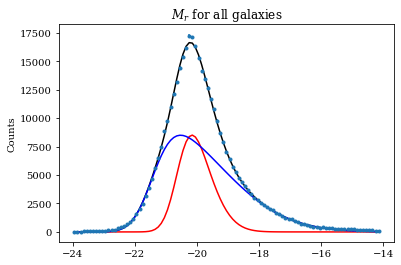

[ 1.15997745e+04 -2.05872120e+01  8.06014495e-01  1.97742300e+00
  2.58916486e+04 -2.14185803e+01  2.11627778e+00  3.92895187e+00] [8.16672550e+02 1.81097866e-02 3.07206968e-02 1.62765134e-01
 7.93387941e+02 3.62553371e-02 5.34793027e-02 2.70949781e-01]


In [11]:
rabsmag_all_fit_uni = fit_unimodal(char_=vollim['ELPETRO_ABSMAG'][:,4],
                                   bins=rabsmag_bins, 
                                   p0_=[20000, -20, 0.75, -2.25], 
                                   label=r'$M_r$ for all galaxies')

rabsmag_all_fit_bi = fit_bimodal(char_=vollim['ELPETRO_ABSMAG'][:,4],
                                 bins=rabsmag_bins, 
                                 p0_=[20000, -20, 0.75, -2.25, 20000, -20, 0.75, -2.25], 
                                 label=r'$M_r$ for all galaxies')

In [12]:
all_uni = minimize_scalar(lambda x: -func_unimodal(x, *rabsmag_all_fit_uni[0]), bounds=(-22,-18), method='bounded')
all_bi = minimize_scalar(lambda x: -func_bimodal(x, *rabsmag_all_fit_bi[0]), bounds=(-22,-18), method='bounded')

rabsmag_max_all_uni = all_uni.x
rabsmag_max_all_bi = all_bi.x

print(rabsmag_max_all_uni, rabsmag_max_all_bi)

-20.24532283353605 -20.21181956881202


## VoidFinder void

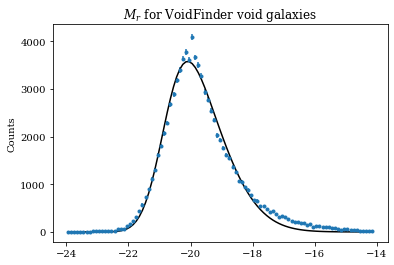

[ 8.25812508e+03 -2.08255780e+01  1.43965809e+00  2.41041408e+00] [8.78974877e+01 2.09941572e-02 3.04488034e-02 1.58562455e-01]


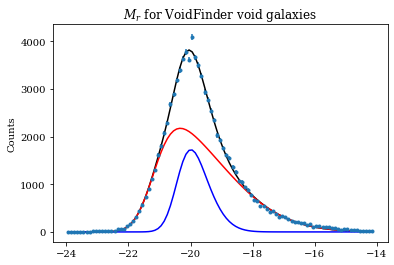

[ 6.39098230e+03 -2.11839067e+01  2.05156547e+00  4.05121128e+00
  2.20312415e+03 -2.03907140e+01  7.52390277e-01  1.95448038e+00] [2.25749877e+02 4.07219569e-02 6.26264462e-02 3.43754581e-01
 2.32856369e+02 2.74631577e-02 4.60438382e-02 2.67831382e-01]


In [13]:
rabsmag_VF_fit_uni = fit_unimodal(char_=catalog_main['ELPETRO_ABSMAG'][:,4],
                                  class_=void_vf,
                                  bins=rabsmag_bins, 
                                  p0_=[20000, -20, 0.75, -2.25], 
                                  label=r'$M_r$ for VoidFinder void galaxies')

rabsmag_VF_fit_bi = fit_bimodal(char_=catalog_main['ELPETRO_ABSMAG'][:,4],
                                class_=void_vf,
                                bins=rabsmag_bins, 
                                p0_=[20000, -20, 0.75, -2.25, 20000, -20, 0.75, -2.25], 
                                label=r'$M_r$ for VoidFinder void galaxies')

In [14]:
VF_uni = minimize_scalar(lambda x: -func_unimodal(x, *rabsmag_VF_fit_uni[0]), bounds=(-22,-18), method='bounded')
VF_bi = minimize_scalar(lambda x: -func_bimodal(x, *rabsmag_VF_fit_bi[0]), bounds=(-22,-18), method='bounded')

rabsmag_max_VF_uni = VF_uni.x
rabsmag_max_VF_bi = VF_bi.x

print(rabsmag_max_VF_uni, rabsmag_max_VF_bi)

-20.092797226191564 -20.048130896442252


## V$^2$ voids

6380


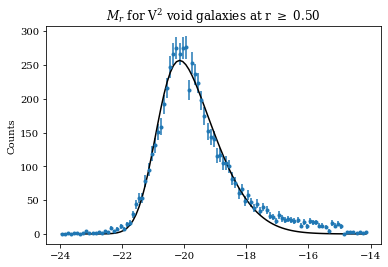

[594.83335883 -20.87378951   1.50453857   2.83934481] [8.33677353 0.02370826 0.03794096 0.23097143]


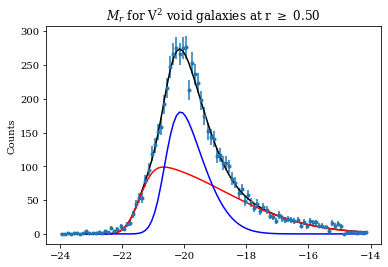

[354.07222467 -21.4412928    2.69564223   7.54192424 278.21971987
 -20.5985729    1.00844323   2.93085481] [3.54313533e+01 8.03229746e-02 2.01519495e-01 1.76602671e+00
 3.66589478e+01 3.59433122e-02 6.24207827e-02 3.33114102e-01]
12636


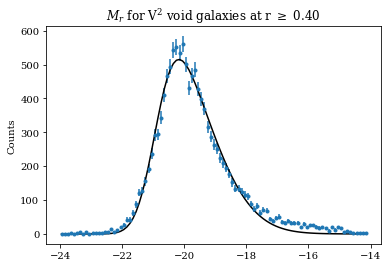

[1192.22744937  -20.89834083    1.49506322    2.77430703] [13.89527161  0.0201102   0.03176111  0.18897337]


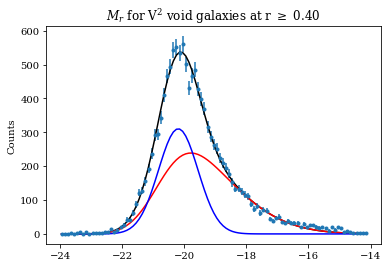

[ 7.48550989e+02 -2.07808992e+01  1.95120024e+00  2.39208038e+00
  4.95843934e+02 -2.01853401e+01  6.37276301e-01 -1.26197318e-02] [5.83486193e+02 1.37490052e+00 4.19167829e-01 3.04180258e+00
 5.82920918e+02 1.21503489e+03 1.26030931e+01 2.39027755e+03]
20721


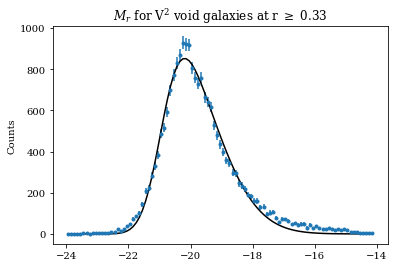

[ 1.96390892e+03 -2.09170641e+01  1.48692638e+00  2.76709319e+00] [2.06077650e+01 1.80617860e-02 2.84824176e-02 1.69828284e-01]


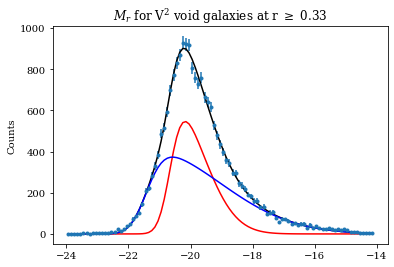

[ 8.45911733e+02 -2.06485713e+01  1.03759179e+00  3.26518496e+00
  1.20780653e+03 -2.14141683e+01  2.35945686e+00  5.43857866e+00] [1.12513951e+02 2.59663917e-02 5.20142561e-02 2.70625411e-01
 1.09965524e+02 7.99426567e-02 1.38670923e-01 9.21419492e-01]
31104


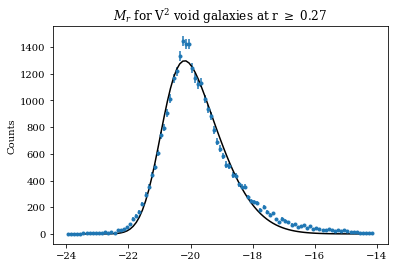

[ 2.94980393e+03 -2.09102470e+01  1.45217443e+00  2.64870800e+00] [3.28791749e+01 1.97175129e-02 3.03094281e-02 1.75279858e-01]


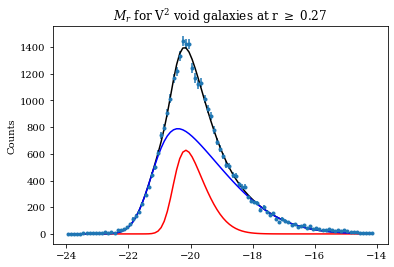

[ 7.86683277e+02 -2.05462844e+01  8.26934235e-01  3.02426927e+00
  2.28328633e+03 -2.12413061e+01  2.02627199e+00  4.10919284e+00] [1.08984259e+02 2.06358065e-02 5.14399977e-02 3.40345097e-01
 1.06129990e+02 5.23902170e-02 7.80451901e-02 4.39989533e-01]
44538


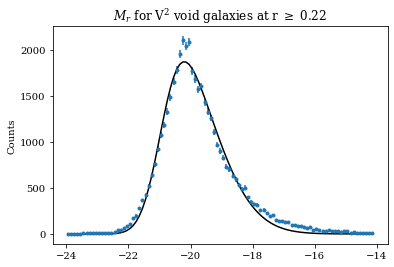

[ 4.23179007e+03 -2.09196468e+01  1.43307896e+00  2.56922273e+00] [4.81156734e+01 2.05955819e-02 3.10825736e-02 1.75477091e-01]


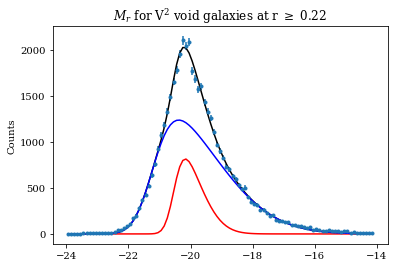

[ 9.35612444e+02 -2.05261556e+01  7.58557918e-01  3.05796024e+00
  3.45669776e+03 -2.12088098e+01  1.92356642e+00  3.75698581e+00] [1.36375837e+02 2.00915857e-02 5.35954452e-02 3.91712509e-01
 1.32849436e+02 4.79522780e-02 6.81985322e-02 3.69106641e-01]
62095


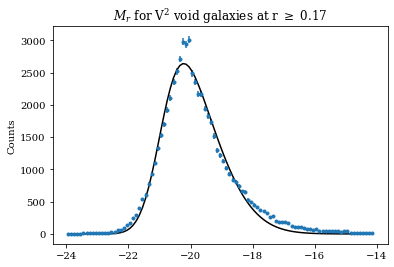

[ 5.90006588e+03 -2.09293326e+01  1.40812043e+00  2.51160305e+00] [7.14817730e+01 2.21771852e-02 3.30078302e-02 1.84539902e-01]


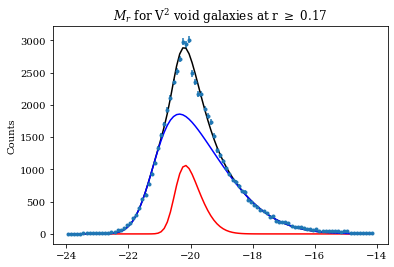

[ 1.08225916e+03 -2.04935742e+01  6.50193447e-01  2.63474950e+00
  5.03793024e+03 -2.11800572e+01  1.84154432e+00  3.48967731e+00] [1.46746754e+02 2.25131991e-02 5.30180696e-02 4.35065027e-01
 1.42884974e+02 4.01918437e-02 5.77722580e-02 3.02920542e-01]
85110


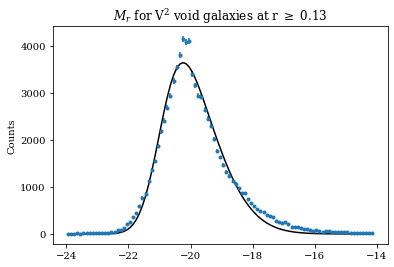

[ 8.08844130e+03 -2.09439658e+01  1.38873814e+00  2.45205094e+00] [1.00403989e+02 2.31039887e-02 3.38731474e-02 1.86582279e-01]


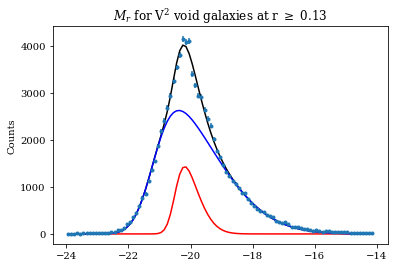

[ 1.36867235e+03 -2.04898855e+01  6.09247216e-01  2.65258330e+00
  7.01741509e+03 -2.11881675e+01  1.80325317e+00  3.41368553e+00] [1.70353893e+02 2.07581922e-02 4.81317568e-02 4.30942319e-01
 1.66762035e+02 3.55808377e-02 5.10730828e-02 2.69481797e-01]
115628


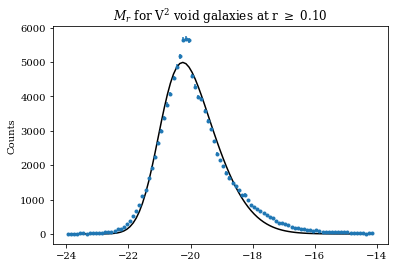

[ 1.09955252e+04 -2.09544777e+01  1.36791743e+00  2.35764420e+00] [1.39615905e+02 2.45015643e-02 3.50310873e-02 1.87076187e-01]


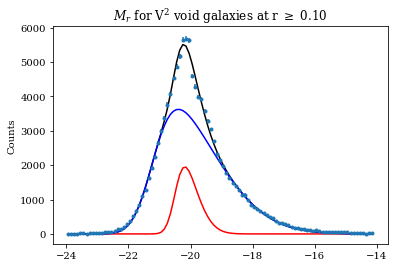

[ 1.81129929e+03 -2.04808438e+01  5.75489990e-01  2.35585882e+00
  9.58935182e+03 -2.12016477e+01  1.77904127e+00  3.31172083e+00] [2.24077966e+02 2.37909308e-02 4.92449878e-02 4.32950943e-01
 2.19889525e+02 3.57324949e-02 5.09322185e-02 2.63770733e-01]
156341


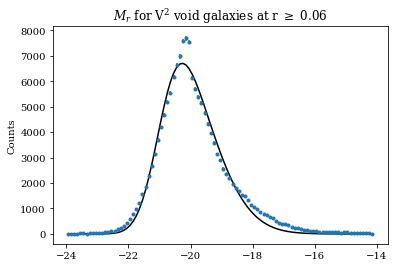

[ 1.48807571e+04 -2.09743590e+01  1.36766995e+00  2.30517450e+00] [1.90155967e+02 2.54057924e-02 3.57953622e-02 1.86308342e-01]


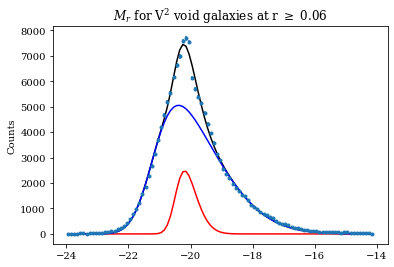

[ 2.13420248e+03 -2.04635153e+01  5.16206514e-01  2.08852090e+00
  1.32701686e+04 -2.11990630e+01  1.74056226e+00  3.11395014e+00] [2.37914363e+02 2.59975892e-02 4.73682744e-02 4.40416449e-01
 2.36170708e+02 3.07667232e-02 4.35804393e-02 2.16829008e-01]
205744


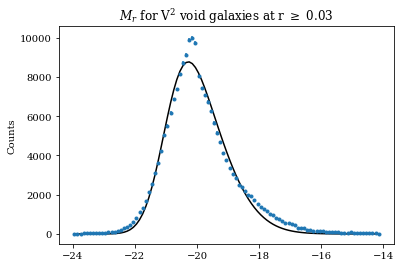

[ 1.96107184e+04 -2.09852463e+01  1.36969201e+00  2.25678804e+00] [2.41294589e+02 2.52208520e-02 3.50359635e-02 1.77727850e-01]


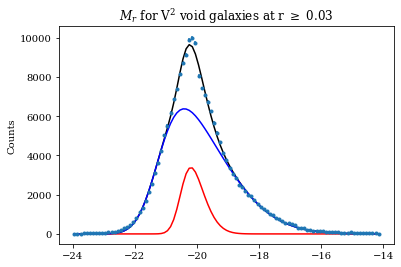

[ 3.23321976e+03 -2.04962474e+01  5.71343235e-01  2.07513062e+00
  1.70890956e+04 -2.12376442e+01  1.77931256e+00  3.14259378e+00] [3.75481842e+02 2.62118488e-02 4.91890110e-02 3.98151690e-01
 3.67488932e+02 3.50072194e-02 4.82631392e-02 2.34497523e-01]
247281


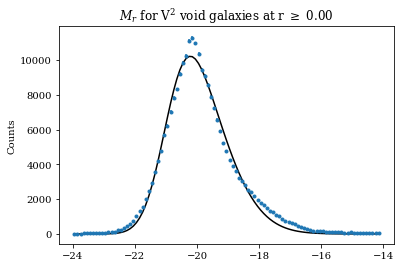

[ 2.36949448e+04 -2.09463767e+01  1.40142050e+00  2.14591502e+00] [2.41426665e+02 2.29445005e-02 3.07951910e-02 1.44320866e-01]


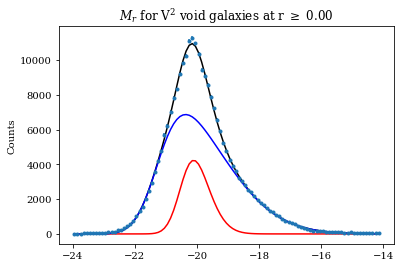

[ 5.04581024e+03 -2.04642784e+01  6.60849563e-01  1.59039308e+00
  1.95067628e+04 -2.12464211e+01  1.87892006e+00  3.08205783e+00] [3.84420441e+02 2.45356063e-02 3.75097993e-02 2.24322411e-01
 3.71837784e+02 2.85632086e-02 3.67993713e-02 1.64242170e-01]


In [16]:
# Number of slices
N = 10

# Volume of inner-most slice (r = 0.5)
r_in = 0.5
V_in = r_in**3 # Normalized by 4/3*pi, since this is the volume of the entire volume

# volume-spacing
d_vol = (4./3.)*np.pi*(1 - V_in)/N

# Initialize variable that will store the previous radius value
r_limits = np.zeros(N+1, dtype=float)
r_limits[0] = r_in

# Initialize arrays that will store the maxima
rabsmag_max_V2_uni = -1*np.ones(N+1, dtype=float)
rabsmag_max_V2_bi = -1*np.ones(N+1, dtype=float)

for i in range(N + 1):
    
    # Calculate minimum radius of this slice
    if i != 0:
        r_limits[i] = 1 - ((1 - r_limits[i - 1])**3 + (3*d_vol/(4*np.pi)))**(1./3.)
    
    # Select all V2 void galaxies with normalized void depths greater than or equal to this value
    gals_in = (catalog_main['V2_depth'] >= r_limits[i]) & void_v2
    print(np.sum(gals_in))
    
    # Fit this distribution
    rabsmag_V2slice_fit_uni = fit_unimodal(char_=catalog_main['ELPETRO_ABSMAG'][:,4], 
                                           class_=gals_in, 
                                           bins=rabsmag_bins, 
                                           p0_=[2000, -20, 0.75, -2.25], 
                                           label=r'$M_r$ for V$^2$ void galaxies at r $\geq$ {:.2f}'.format(r_limits[i]))
    rabsmag_V2slice_fit_bi = fit_bimodal(char_=catalog_main['ELPETRO_ABSMAG'][:,4], 
                                         class_=gals_in, 
                                         bins=rabsmag_bins, 
                                         p0_=[1000, -20, 1, -2, 1000, -19.5, 0.5, -1.5], 
                                         label=r'$M_r$ for V$^2$ void galaxies at r $\geq$ {:.2f}'.format(r_limits[i]))
    
    # Calculate local maxima
    V2_uni = minimize_scalar(lambda x: -func_unimodal(x, *rabsmag_V2slice_fit_uni[0]), 
                             bounds=(-22,-18), 
                             method='bounded')
    V2_bi = minimize_scalar(lambda x: -func_bimodal(x, *rabsmag_V2slice_fit_bi[0]), 
                             bounds=(-22,-18), 
                             method='bounded')
    
    # Save maximum location
    rabsmag_max_V2_uni[i] = V2_uni.x
    rabsmag_max_V2_bi[i] = V2_bi.x

## Plot results

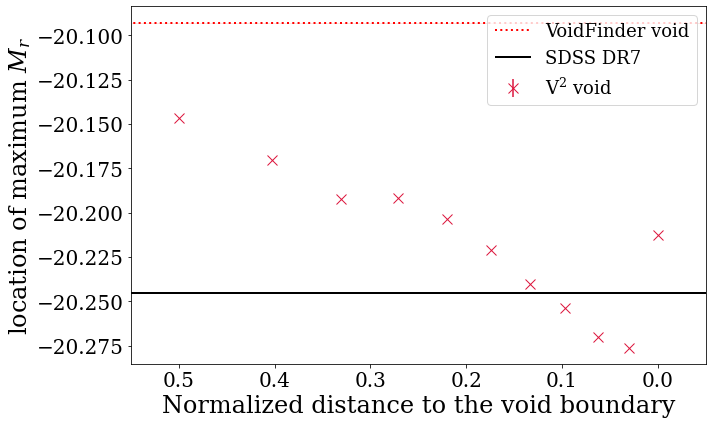

In [17]:
depth_plot(rabsmag_max_VF_uni, 0., 
           rabsmag_max_all_uni, 0., 
           rabsmag_max_V2_uni, np.zeros(len(rabsmag_max_V2_uni)), 
           r_limits, 
           y_label='location of maximum $M_r$', 
           #filename='sSFR_depth'
           )

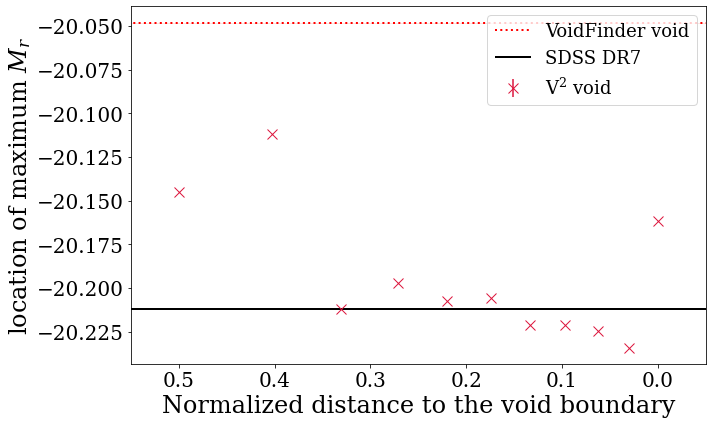

In [18]:
depth_plot(rabsmag_max_VF_bi, 0., 
           rabsmag_max_all_bi, 0., 
           rabsmag_max_V2_bi, np.zeros(len(rabsmag_max_V2_bi)), 
           r_limits, 
           y_label='location of maximum $M_r$', 
           #filename='sSFR_depth'
           )